In [4]:
import os
import math
import glob

import pandas
import numpy
import librosa

#import librosa.display
import matplotlib
from matplotlib import pyplot as plt
import seaborn


In [5]:

time_resolution = 0.020


In [25]:

def load_spectrogram(path, sr=16000, mels=32, time_resolution=0.020):
    y, sr = librosa.load(path, sr=sr)

    hop_length = int(time_resolution * sr)
    n_fft = hop_length * 2
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=mels, hop_length=hop_length, n_fft=n_fft)

    S_db = librosa.power_to_db(S)
    return S_db

def load_files(path):

    out = []
    for name in glob.glob('*.ogg', root_dir=path):
        p = os.path.join(path, name)
        S = load_spectrogram(p, time_resolution=time_resolution)
        
        d = {
            'file': name,
            'spectrogram': S,
        }
        out.append(d)
    df = pandas.DataFrame.from_records(out)
    return df

files = load_files('./data/cleaned')
files['condition'] = files['file'].apply(lambda f: '_'.join(f.split('_')[:-1]))
files['section'] = files['file'].apply(lambda f: os.path.splitext(f.split('_')[-1])[0]).astype(int)
files = files.set_index(['condition', 'section'])
files

file  \
condition           section                              
VID_20240302_191946 4        VID_20240302_191946_4.ogg   
VID_20240302_192143 2        VID_20240302_192143_2.ogg   
VID_20240302_192737 7        VID_20240302_192737_7.ogg   
                    4        VID_20240302_192737_4.ogg   
VID_20240302_191619 2        VID_20240302_191619_2.ogg   
...                                                ...   
VID_20240302_192357 7        VID_20240302_192357_7.ogg   
VID_20240302_192629 5        VID_20240302_192629_5.ogg   
VID_20240302_191813 4        VID_20240302_191813_4.ogg   
VID_20240302_192737 2        VID_20240302_192737_2.ogg   
VID_20240302_192629 1        VID_20240302_192629_1.ogg   

                                                                   spectrogram  
condition           section                                                     
VID_20240302_191946 4        [[-36.87933, -33.669888, -37.881294, -33.87906...  
VID_20240302_192143 2        [[-35.86687, -34.017673, -34.162365, -32.62513...  
VID_20240302_192737 7        [[-33.906845, -31.3461, -31.21463, -32.74732, ...  
                    4        [[-39.617695, -35.907555, -31.06591, -34.09235...  
VID_20240302_191619 2        [[-45.582577, -38.402565, -34.639267, -39.7598...  
...                                                                        ...  
VID_20240302_192357 7        [[-36.740757, -34.05067, -31.349567, -32.59253...  
VID_20240302_192629 5        [[-32.262527, -27.28092, -0.8379599, 4.270774,...  
VID_20240302_191813 4        [[-29.452145, -28.132801, -22.414589, 5.863269...  
VID_20240302_192737 2        [[-35.796093, -33.48942, -33.059692, -34.9912,...  
VID_20240302_192629 1        [[-31.999012, -31.357246, -30.417114, -30.3202...  

[79 rows x 2 columns]

In [18]:
def load_conditions(path):

    df = pandas.read_csv(path)
    df = df.set_index('file')

    return df

def load_balls(path):
    df = pandas.read_csv(path)
    df = df.set_index('ball')
    
    return df

conditions_path = './data/cleaned/conditions.csv'
conditions = load_conditions(conditions_path)
balls_path = './data/cleaned/balls.csv'
balls = load_balls(balls_path)

conditions = pandas.merge(conditions, balls, left_on='ball', right_index=True)
conditions

,ball,height,diameter
file,,,
VID_20240302_191619,plastic_big,220.0,20.0
VID_20240302_191813,plastic_big,150.0,20.0
VID_20240302_191946,plastic_big,70.0,20.0
VID_20240302_192143,plastic_small,220.0,10.0
VID_20240302_192248,plastic_small,150.0,10.0
VID_20240302_192357,plastic_small,70.0,10.0
VID_20240302_192510,tennis,220.0,7.0
VID_20240302_192629,tennis,150.0,7.0
VID_20240302_192737,tennis,70.0,7.0


In [26]:

def compute_soundlevel(S, time_resolution):

    e = librosa.db_to_power(S)
    e_time = librosa.power_to_db(e.sum(axis=0))
    #e = S.sum(axis=0)
    
    tt = numpy.arange(len(e_time)) * time_resolution
    df = pandas.DataFrame({
        'energy': e_time,
        'time': tt,
    }).set_index('time')
    return df
    

def normalize_energy(e):
    min = numpy.min(e, axis=0)
    #max = numpy.max(e, axis=0)

    n = e - min
    n = n / numpy.max(n, axis=0)
    
    return n


def relative_soundlevel(S, time_resolution):
    sl = compute_soundlevel(S, time_resolution=time_resolution)

    # scale to 0.0-1.0
    n = normalize_energy(sl)
    return n
    

def compute_peakyness(levels):
    
    # bounces have both a high soundlevel, and a rapid change in soundlevel
    p = levels * levels.diff(1).abs()

    peakyness = normalize_energy(p)
    
    return peakyness


def merge_events(times, min_distance=0.01):
    # XXX: assumes that times are sorted, increasing order
    out = []
    previous_t = float('-inf')
    for t in times:
        dt = t - previous_t
        if dt >= min_distance:
            previous_t = t
            out.append(t)

    return numpy.array(out)


def find_bounce_times(peakyness, threshold=0.50):
    p = normalize_energy(peakyness)
    bounces = p[p.energy >= threshold]
    bb = merge_events(bounces.index, min_distance=time_resolution*4.0)

    return bb

    
files['soundlevel'] = files.spectrogram.apply(relative_soundlevel, time_resolution=time_resolution)
files['peakyness'] = files['soundlevel'].apply(compute_peakyness)
files['peak_threshold'] = 0.25
files['bounce_times'] = files.peakyness.apply(find_bounce_times, threshold=0.25)

files

file  \
condition           section                              
VID_20240302_191946 4        VID_20240302_191946_4.ogg   
VID_20240302_192143 2        VID_20240302_192143_2.ogg   
VID_20240302_192737 7        VID_20240302_192737_7.ogg   
                    4        VID_20240302_192737_4.ogg   
VID_20240302_191619 2        VID_20240302_191619_2.ogg   
...                                                ...   
VID_20240302_192357 7        VID_20240302_192357_7.ogg   
VID_20240302_192629 5        VID_20240302_192629_5.ogg   
VID_20240302_191813 4        VID_20240302_191813_4.ogg   
VID_20240302_192737 2        VID_20240302_192737_2.ogg   
VID_20240302_192629 1        VID_20240302_192629_1.ogg   

                                                                   spectrogram  \
condition           section                                                      
VID_20240302_191946 4        [[-36.87933, -33.669888, -37.881294, -33.87906...   
VID_20240302_192143 2        [[-35.86687, -34.017673, -34.162365, -32.62513...   
VID_20240302_192737 7        [[-33.906845, -31.3461, -31.21463, -32.74732, ...   
                    4        [[-39.617695, -35.907555, -31.06591, -34.09235...   
VID_20240302_191619 2        [[-45.582577, -38.402565, -34.639267, -39.7598...   
...                                                                        ...   
VID_20240302_192357 7        [[-36.740757, -34.05067, -31.349567, -32.59253...   
VID_20240302_192629 5        [[-32.262527, -27.28092, -0.8379599, 4.270774,...   
VID_20240302_191813 4        [[-29.452145, -28.132801, -22.414589, 5.863269...   
VID_20240302_192737 2        [[-35.796093, -33.48942, -33.059692, -34.9912,...   
VID_20240302_192629 1        [[-31.999012, -31.357246, -30.417114, -30.3202...   

                                                                    soundlevel  \
condition           section                                                      
VID_20240302_191946 4                energy
time          
0.00  0.020810
0...   
VID_20240302_192143 2                energy
time          
0.00  0.016100
0...   
VID_20240302_192737 7                energy
time          
0.00  0.012813
0...   
                    4                energy
time          
0.00  0.000000
0...   
VID_20240302_191619 2                 energy
time           
0.00   0.28732...   
...                                                                        ...   
VID_20240302_192357 7                energy
time          
0.00  0.000000
0...   
VID_20240302_192629 5                energy
time          
0.00  0.029146
0...   
VID_20240302_191813 4                energy
time          
0.00  0.122550
0...   
VID_20240302_192737 2                energy
time          
0.00  0.000000
0...   
VID_20240302_192629 1                energy
time          
0.00  0.061648
0...   

                                                                     peakyness  \
condition           section                                                      
VID_20240302_191946 4                energy
time          
0.00       NaN
0...   
VID_20240302_192143 2                energy
time          
0.00       NaN
0...   
VID_20240302_192737 7                energy
time          
0.00       NaN
0...   
                    4                energy
time          
0.00       NaN
0...   
VID_20240302_191619 2                 energy
time           
0.00        Na...   
...                                                                        ...   
VID_20240302_192357 7                energy
time          
0.00       NaN
0...   
VID_20240302_192629 5                energy
time          
0.00       NaN
0...   
VID_20240302_191813 4                energy
time          
0.00       NaN
0...   
VID_20240302_192737 2                energy
time          
0.00       NaN
0...   
VID_20240302_192629 1                energy
time          
0.00       NaN
0...   

                             peak_threshold  \
condition           section                   


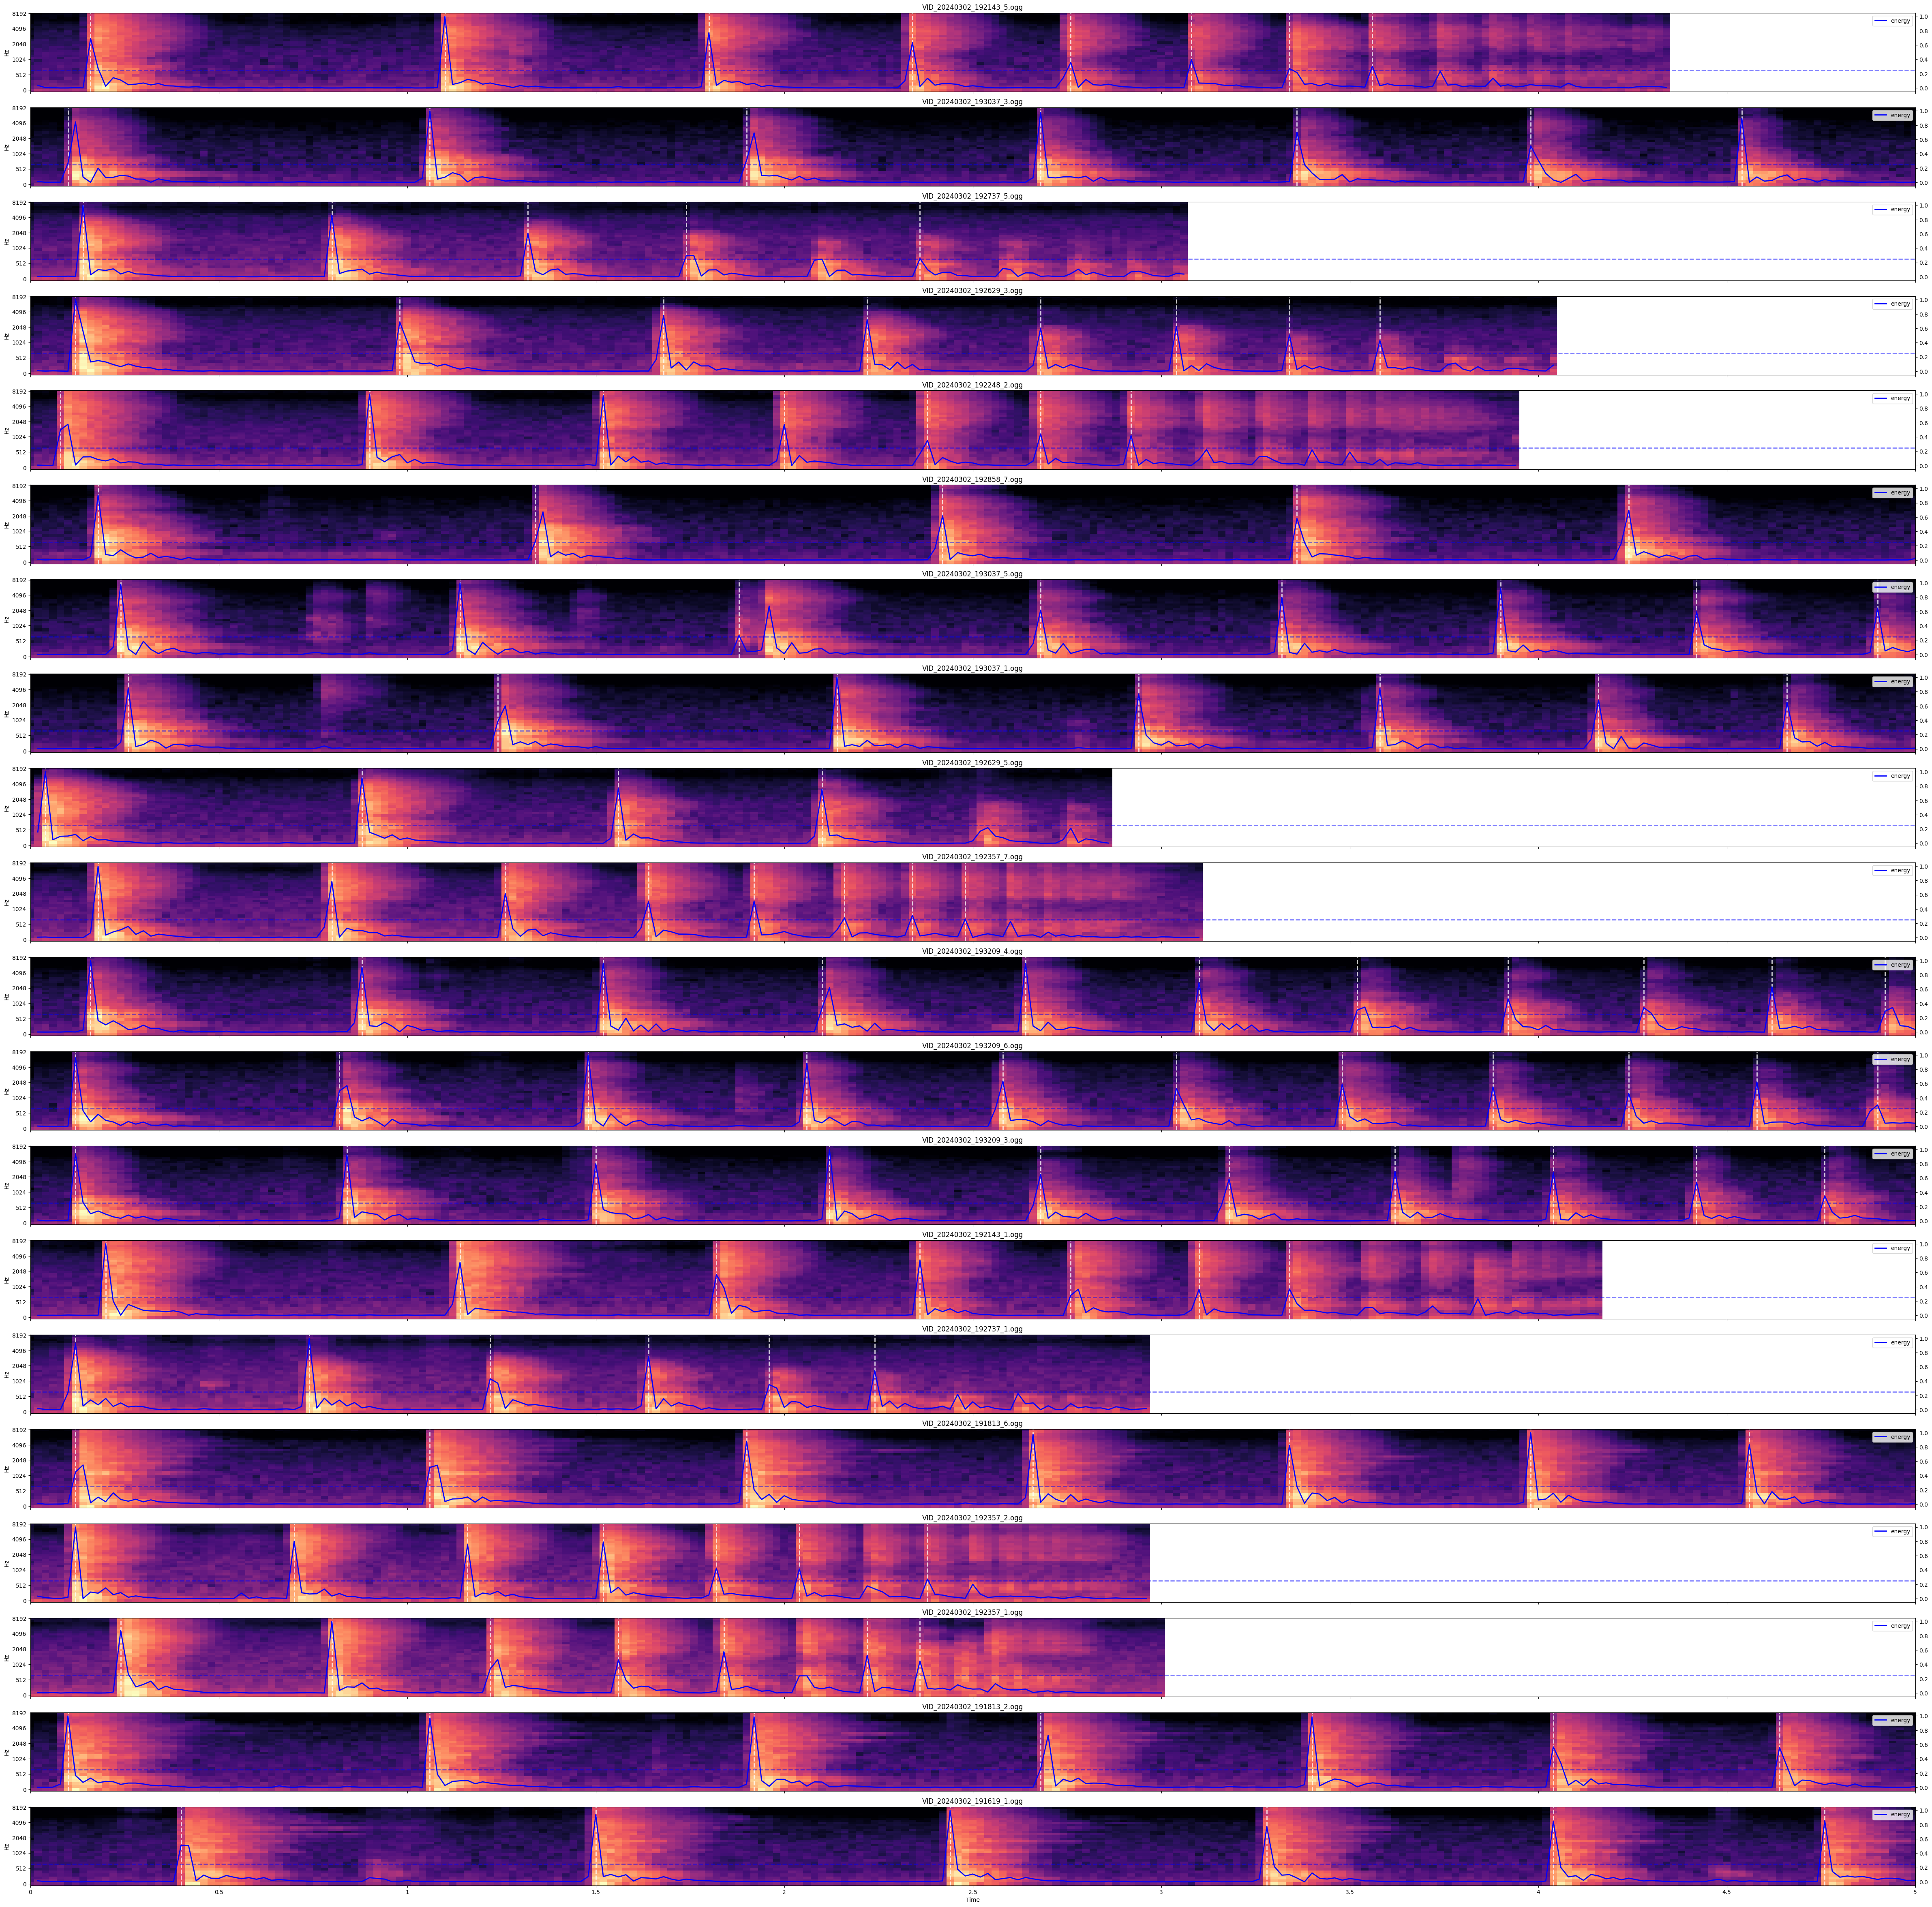

In [22]:

def plot_file(row, ax=None, sr=16000):

    ax.set_title(row['file'])
    hop = int(time_resolution * sr)

    # Spectrogram
    S = row['spectrogram']    
    librosa.display.specshow(ax=ax, data=S,
                             y_axis='mel', x_axis='time',
                             sr=sr, hop_length=hop,
                             cmap='magma')

    # Bounce detection
    ax2 = ax.twinx()

    p = row['peakyness']
    p.plot(ax=ax2, color='blue', lw=2.0)
    
    threshold = row['peak_threshold']
    ax2.axhline(y=threshold, color='blue', lw=2.0, ls='--', alpha=0.5)
    
    bounces = row['bounce_times']
    for t in bounces:
        ax.axvline(x=t, color='white', lw=2.0, ls='--', alpha=0.8)
    


def plot_files(files, height=3.0, aspect=1.0):
    h = len(files) * height
    w = h * aspect
    fig, axs = plt.subplots(len(files), figsize=(w, h), sharex=True, sharey=True)

    for ax, (idx, row) in zip(axs, files.iterrows()):
        plot_file(row, ax=ax)
        ax.set_xlim(0, 5.0)


plot_files(files.sample(n=20))




In [64]:
def extract_pairs(values):
    out = []

    for s, e in zip(values, values[1:]):
        out.append((s, e))

    o = numpy.stack(out)
    return o

def extract_bounce_pairs(files):

    out = []
    for idx, row in files.iterrows():

        bounces = row['bounce_times']
        deltas = numpy.diff(bounces)
        pairs = extract_pairs(deltas)
        
        for i, p in enumerate(pairs):
            d = {
                'condition': idx[0],
                'section': idx[1],
                'bounce_no': i,
                'dt1': p[0],
                'dt2': p[1],
                # XXX: also capture time ?
            }
            out.append(d)
    
    df = pandas.DataFrame.from_records(out)
    df = df.set_index(['condition', 'section'])
    return df

pairs = extract_bounce_pairs(files)
pairs['ratio'] = pairs.dt2 / pairs.dt1
pairs['bounce_height'] = (9.81/8.0) * (pairs.dt1**2)
pairs = pairs[pairs.bounce_no < 10]
pairs

bounce_no   dt1   dt2     ratio  bounce_height
condition           section                                                
VID_20240302_191946 4                0  0.64  0.60  0.937500       0.502272
                    4                1  0.60  0.56  0.933333       0.441450
                    4                2  0.56  0.50  0.892857       0.384552
                    4                3  0.50  0.48  0.960000       0.306563
                    4                4  0.48  0.46  0.958333       0.282528
...                                ...   ...   ...       ...            ...
VID_20240302_192629 1                1  0.68  0.52  0.764706       0.567018
                    1                2  0.52  0.44  0.846154       0.331578
                    1                3  0.44  0.34  0.772727       0.237402
                    1                4  0.34  0.28  0.823529       0.141754
                    1                5  0.28  0.22  0.785714       0.096138

[577 rows x 5 columns]

In [65]:

p = pairs.reset_index()
p = pandas.merge(p, conditions, left_on='condition', right_index=True)
p



,condition,section,bounce_no,dt1,dt2,ratio,bounce_height,ball,height,diameter
0,VID_20240302_191946,4,0,0.64,0.60,0.937500,0.502272,plastic_big,70.0,20.0
1,VID_20240302_191946,4,1,0.60,0.56,0.933333,0.441450,plastic_big,70.0,20.0
2,VID_20240302_191946,4,2,0.56,0.50,0.892857,0.384552,plastic_big,70.0,20.0
3,VID_20240302_191946,4,3,0.50,0.48,0.960000,0.306563,plastic_big,70.0,20.0
4,VID_20240302_191946,4,4,0.48,0.46,0.958333,0.282528,plastic_big,70.0,20.0
...,...,...,...,...,...,...,...,...,...,...
572,VID_20240302_192629,1,1,0.68,0.52,0.764706,0.567018,tennis,150.0,7.0
573,VID_20240302_192629,1,2,0.52,0.44,0.846154,0.331578,tennis,150.0,7.0
574,VID_20240302_192629,1,3,0.44,0.34,0.772727,0.237402,tennis,150.0,7.0
575,VID_20240302_192629,1,4,0.34,0.28,0.823529,0.141754,tennis,150.0,7.0


In [66]:
ball_order = p.groupby('ball').ratio.mean().sort_values()

ball_order.index

Index(['plastic_small', 'tennis', 'sprett', 'plastic_big'], dtype='object', name='ball')

[(0.5, 1.1)]

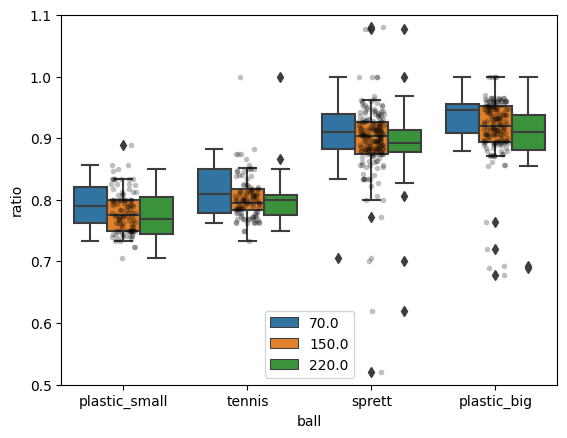

In [67]:

g = seaborn.boxplot(data=p, x='ball', hue='height', y='ratio', order=ball_order.index)
g = seaborn.stripplot(data=p, x='ball', y='ratio', color='black', order=ball_order.index, alpha=0.25, s=4.0)
g.set(ylim=(0.50, 1.1))


ball           height
plastic_big    70.0       56.136148
               150.0     130.771205
               220.0     178.928413
plastic_small  70.0       70.828200
               150.0     130.663892
               220.0     183.113951
sprett         70.0       74.591756
               150.0     138.289921
               220.0     214.643926
tennis         70.0       81.509389
               150.0     143.332669
               220.0     199.342266
Name: est_height, dtype: float64

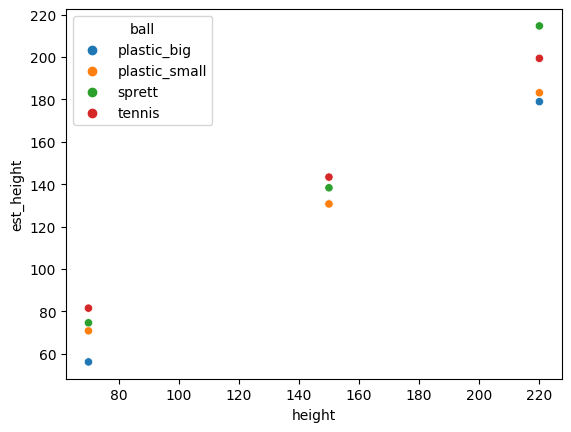

In [83]:

def compute_height(df):

    cor = df['ratio'].median()
    est_height = df[df['bounce_no'] == 0]['bounce_height'] * (1/(cor**2))
    #est_height = df[df['bounce_no'] == 1]['bounce_height'] * (1/(cor**2)) * (1/(cor**2))

    h = est_height.median() * 100
    return h
    

heights = p.groupby(['ball', 'height']).apply(compute_height)
heights.name = 'est_height'

seaborn.scatterplot(data=heights.reset_index(), x='height', y='est_height', hue='ball')

heights
